In [23]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from face_segmenter import segment_image,rgb2gray
import numpy as np
import skops.io as sio
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
import pandas as pd

In [24]:
from joblib import load
with open("models/pipe_kmeans64.sio","br") as f:
    obj = f.read()
    unknown_types = sio.get_untrusted_types(data=obj)
    clf = sio.loads(obj,trusted=unknown_types)
    
P_pos_q_cara = np.load("counts/pipe_kmeans64/P_pos_q_cara.npy") + 1
P_q_nocara = np.load("counts/pipe_kmeans64/P_q_nocara.npy") + 1 
P_q_cara = np.load("counts/pipe_kmeans64/P_q_cara.npy") + 1

P_norm_pos_q_cara = P_pos_q_cara / P_pos_q_cara.sum(axis=0)
P_norm_q_cara = P_q_cara / P_q_cara.sum()
P_norm_q_nocara = P_q_nocara / P_q_nocara.sum()

In [25]:
def is_cara_region(region:np.ndarray)-> bool:
    q = region.flatten()

    n = len(q)
    r = len(P_norm_q_nocara)
    den = np.prod(P_norm_q_nocara[q]/ (n*r)) 
    num = np.prod(P_norm_pos_q_cara[np.arange(0,n,1,dtype=int),q]) * np.prod(P_norm_q_cara[q])

    res = num / den
    
    return res

In [26]:
x1 = 45
y1 = 85
w1 = 90
h1 = 90

In [27]:
csv_path = "/media/nacho/datasets/CelebA/list_bbox_celeba.csv"
images_dir = "/media/nacho/datasets/CelebA/img_align_celeba/img_align_celeba"

In [28]:
image_path = os.listdir(images_dir)[1040]
image_path = images_dir + "/" + image_path 
img = cv2.imread(image_path)
img = rgb2gray(np.array(img))

face = img[y1:y1+h1,x1:x1+w1]
face = cv2.resize(face,(32,32))




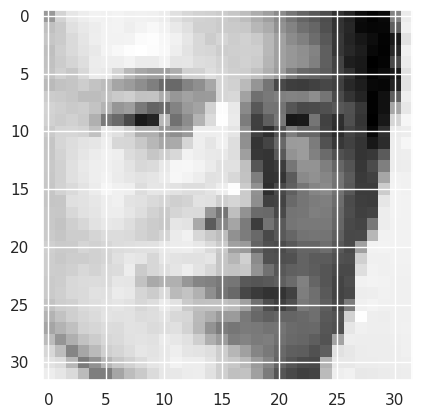

In [29]:
plt.imshow(face,cmap="gray")

In [30]:
mini_patches,shape = segment_image(face,tile_size=8)
mini_patches = mini_patches.reshape(-1,8*8)
y_pred = clf.predict(mini_patches)
y_pred = y_pred.reshape(shape[0]//8,shape[1]//8)

In [31]:
is_cara_region(y_pred)

1.3691704902749108e+43

In [32]:
found = []
for image_path in os.listdir(images_dir):
    image_path = images_dir + "/" + image_path 

    img = cv2.imread(image_path)
    img = rgb2gray(np.array(img))

    face = img[y1:y1+h1,x1:x1+w1]
    face = cv2.resize(face,(32,32))

    mini_patches,shape = segment_image(face,tile_size=8)
    mini_patches = mini_patches.reshape(-1,8*8)
    y_pred = clf.predict(mini_patches)
    y_pred = y_pred.reshape(shape[0]//8,shape[1]//8)

    found.append(is_cara_region(y_pred))

In [33]:
found_np = np.array(found)


In [34]:
peor = found_np.argmin()

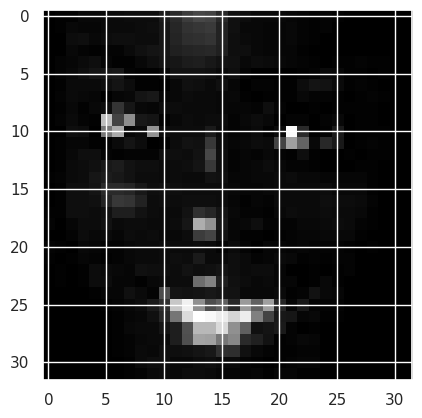

In [35]:
image_path = os.listdir(images_dir)[peor]
image_path = images_dir + "/" + image_path 

img = cv2.imread(image_path)
img = rgb2gray(np.array(img))

face = img[y1:y1+h1,x1:x1+w1]
face = cv2.resize(face,(32,32))

plt.imshow(face,cmap="gray")

<Axes: ylabel='Count'>

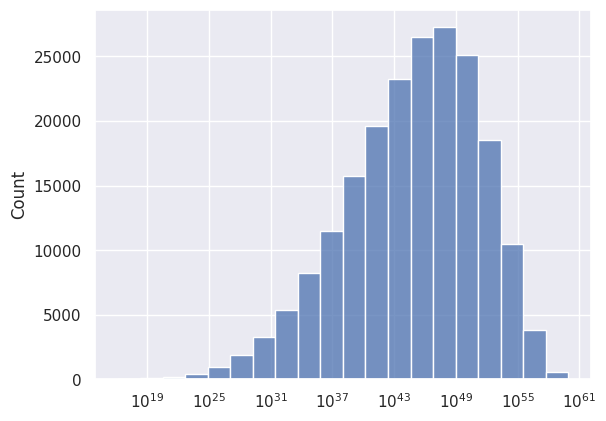

In [36]:
sns.set_style()
sns.set_context("talk")
sns.set_theme()

sns.histplot(found_np,bins=20,log_scale=True)

In [37]:
natural_images_path = "/media/nacho/datasets/natural_images"

natural_images_list = []

for data_folder in os.listdir(natural_images_path):
    if data_folder == "person": continue
    for image in os.listdir(os.path.join(natural_images_path,data_folder)):
        img_npy = cv2.imread(os.path.join(natural_images_path,data_folder,image))
        img_npy = rgb2gray(img_npy)
        """for i in range(10):
            img_npy = next_pyramid_step(img_npy)"""
        subregiones,_ = segment_image(img_npy,8*4)
        natural_images_list.append(subregiones)

natural_images = np.concatenate(natural_images_list)



In [38]:
natural_images.shape

(308899, 32, 32)

In [39]:
nat_found = []
for nat_img in natural_images:
    mini_patches,shape = segment_image(nat_img,tile_size=8)
    mini_patches = mini_patches.reshape(-1,8*8)
    y_pred = clf.predict(mini_patches)
    y_pred = y_pred.reshape(shape[0]//8,shape[1]//8)

    nat_found.append(is_cara_region(y_pred))

<Axes: ylabel='Count'>

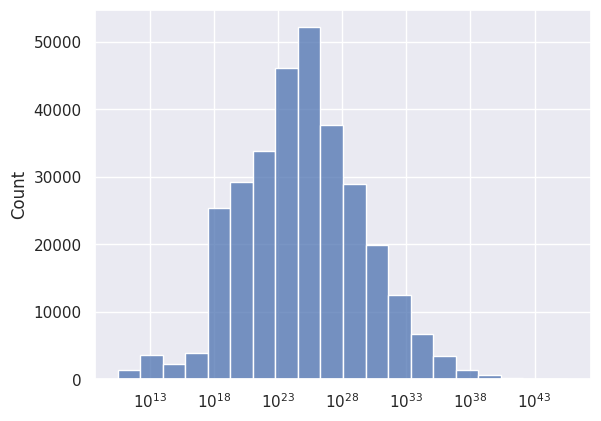

In [40]:
nat_found_np = np.array(nat_found)
sns.histplot(nat_found_np,bins=20,log_scale=True)

In [41]:
df_caras = pd.DataFrame({"p":found_np,"type":"Cara"})

In [42]:
df_natur = pd.DataFrame({"p":nat_found_np,"type":"Natural"})

In [43]:
df = pd.concat([df_natur,df_caras])

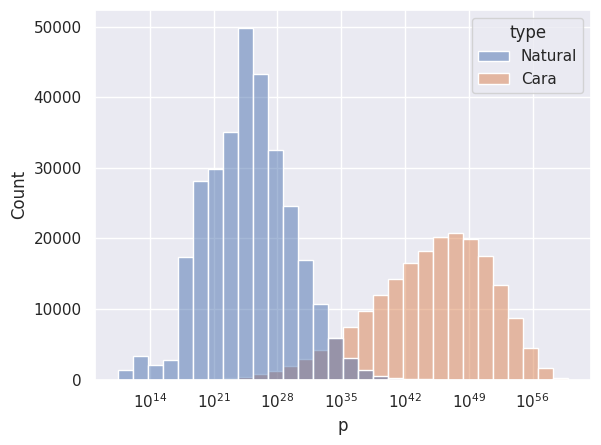

In [44]:
ax = sns.histplot(df,x="p",bins=30,log_scale=True,hue="type")